In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv("all_penguins_clean.csv", index_col=0)


In [6]:
df.shape

(344, 14)

# 1. Imputation

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, PAL0708 to PAL0910
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sample Number        344 non-null    int64  
 1   Species              344 non-null    object 
 2   Region               344 non-null    object 
 3   Island               344 non-null    object 
 4   Stage                344 non-null    object 
 5   Individual ID        344 non-null    object 
 6   Clutch Completion    344 non-null    object 
 7   Date Egg             344 non-null    object 
 8   Culmen Length (mm)   342 non-null    float64
 9   Culmen Depth (mm)    342 non-null    float64
 10  Flipper Length (mm)  342 non-null    float64
 11  Body Mass (g)        342 non-null    float64
 12  Real ID              344 non-null    object 
 13  Sex                  334 non-null    object 
dtypes: float64(4), int64(1), object(9)
memory usage: 40.3+ KB


In [10]:
df.isna().sum()

Sample Number           0
Species                 0
Region                  0
Island                  0
Stage                   0
Individual ID           0
Clutch Completion       0
Date Egg                0
Culmen Length (mm)      2
Culmen Depth (mm)       2
Flipper Length (mm)     2
Body Mass (g)           2
Real ID                 0
Sex                    10
dtype: int64

In [13]:
df["Body Mass (g)"].isna().sum()

2

<AxesSubplot:ylabel='studyName'>

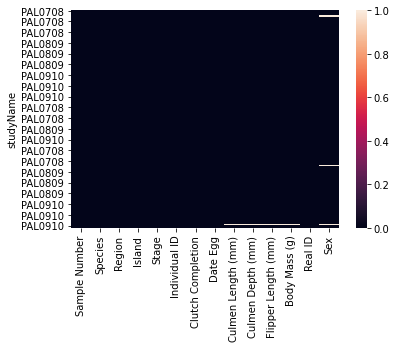

In [14]:
sns.heatmap(df.isna())

In [18]:
# Fix categorical string values:
#df['Sex_fixed'] = df["Sex"].fillna("MISSING") # Create new column
df["Sex"].fillna('MISSING', inplace = True)

In [ ]:
med = df["Flipper Length (mm)"].median()
df.['Flipper Length (mm)'].fillna(med, inplace=True)


Other ideas to try for imputation:
* insert medians by category (eg for sex, for species)
* forward/backward fill/ interpolation (good for timeseries)
* K-Nearest Neighbours (finds the next most similar penguin + copies values from that)

# Feature Engineering Cleanup

## One-Hot-Encoding

In [26]:
from sklearn.preprocessing import OneHotEncoder

**Step 1** : fit() the training data
**Step 2** : transform() the training data

In [27]:
oh = OneHotEncoder(sparse = False, handle_unknown = 'ignore') #also an estimator (but does not give predictions)

In [45]:
oh.fit(df[['Species']])# memorises all the diff categories which are stored in the OH object
oh.categories_

[array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)]

In [29]:
onehot_species = oh.transform(df[['Species']])
onehot_species.shape

(344, 3)

**Step 3:** transform() the test data

Now there is new data is coming in

In [38]:
test_data = pd.DataFrame({'Species': ["Gentoo", "Gentoo", "chinstrap", 'Emperor']})

In [39]:
oh.transform(test_data[["Species"]])

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 1., 0.]])

## **DO NOT CALL fit() ON TEST DATA EVER!!!!!!!!!**

In [42]:
oh.fit(test_data[['Species']]) #forgets that Adelie penguins exist

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

In [44]:
oh.categories_ #<--- can check what categories are being used

[array(['Emperor', 'Gentoo', 'chinstrap'], dtype=object)]

## Scaling


**Step 1:** fit on the training data

**Step 2:** transform() the training data

**Step 3:** transform() the test data

In [47]:
from sklearn.preprocessing import MinMaxScaler

In [52]:
scaler = MinMaxScaler()
scaler.fit(df[['Culmen Length (mm)', "Body Mass (g)"]])
scaler.data_min_, scaler.data_max_

(array([  32.1, 2700. ]), array([  59.6, 6300. ]))

In [54]:
Xt = scaler.transform(df[['Culmen Length (mm)', "Body Mass (g)"]])
Xt.shape

(344, 2)

In [55]:
test_data = pd.DataFrame({"Culmen Length (mm)":[40.0, 50.0], 'Body Mass (g)': [4500, 10000]})
#invented some fake test penguins for demonstration

In [56]:
scaler.transform(new_data[['Culmen Length (mm)', 'Body Mass (g)']])

array([[0.28727273, 0.5       ],
       [0.65090909, 2.02777778]])

### the scaling of the v large mass is above 1.0 b/c the test penguin has v high mass compared to the max of the training data - this is ok!!!

# 3. Binning
Scalar --> Category

In [42]:
df["Body Mass (g)"].fillna(3000.0, inplace= True)

In [54]:
# Quantilised binning: each bin contains approximately the same number of data points
df['weight_cat'] = pd.qcut(df['Body Mass (g)'], q=3, labels=['light', 'medium', 'hevy'] ) #column, number of bins
df['weight_cat'].head()


studyName
PAL0708    medium
PAL0708    medium
PAL0708     light
PAL0708     light
PAL0708     light
Name: weight_cat, dtype: category
Categories (3, object): [light < medium < hevy]

In [55]:
q = pd.qcut(df['Body Mass (g)'], q=3)
q.value_counts()


(2699.999, 3700.0]    119
(4533.333, 6300.0]    115
(3700.0, 4533.333]    110
Name: Body Mass (g), dtype: int64

Alternatives: 
* `pd.cut` - creates bins of equal width
* set bin boundaries manually in pd.cut or pd.qcut

In [48]:
# Next step: one hot encode the weight categories

Species
Adelie       AxesSubplot(0.125,0.125;0.775x0.755)
Chinstrap    AxesSubplot(0.125,0.125;0.775x0.755)
Gentoo       AxesSubplot(0.125,0.125;0.775x0.755)
Name: Body Mass (g), dtype: object

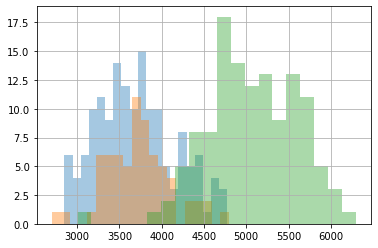

In [57]:
df.groupby("Species")["Body Mass (g)"].hist(bins=20, alpha = 0.4)

# 4. Normalisation

Changen the range and/or distribution of values.

Examples:
* log scale
* rescale to (0.0 ... 1.0)
* rescale to a standard normal distribution

## Log scale

In [58]:
df['log_mass'] = np.log(df['Body Mass (g)'])
df['log_mass'].head()

studyName
PAL0708    8.229511
PAL0708    8.242756
PAL0708    8.086410
PAL0708    8.006368
PAL0708    8.146130
Name: log_mass, dtype: float64

## Min/Max scaling
* Lightest penguin is at 0.0
* heaviest penguin at 1.0
* all other pengiuns are distributed in between 

In [62]:
bm_min = df["Body Mass (g)"].min()
bm_max = df['Body Mass (g)'].max()
bm_range = bm_max - bm_min
bm_range

3600.0

In [64]:
df["mass_scaled"] = (df['Body Mass (g)'] - bm_min )/ bm_range
df['mass_scaled'].head()

studyName
PAL0708    0.291667
PAL0708    0.305556
PAL0708    0.152778
PAL0708    0.083333
PAL0708    0.208333
Name: mass_scaled, dtype: float64

<AxesSubplot:>

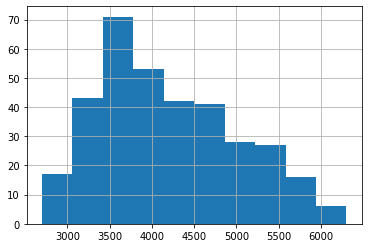

In [65]:
df['Body Mass (g)'].hist()

<AxesSubplot:>

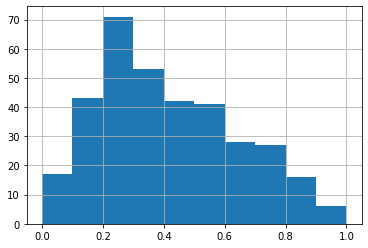

In [66]:
df['mass_scaled'].hist()

The histograms look exactly the same - just the x-scale is different.

The distribtion remains the same, but the LogReg computetion becomes more efficient

**SEE ALSO:** 
* MinMaxScaler
* OneHotEncoder
* ColumnTransformer

in scikit 